In [6]:
import requests
from bs4 import BeautifulSoup as bs4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### check the full graph of gold price growth.

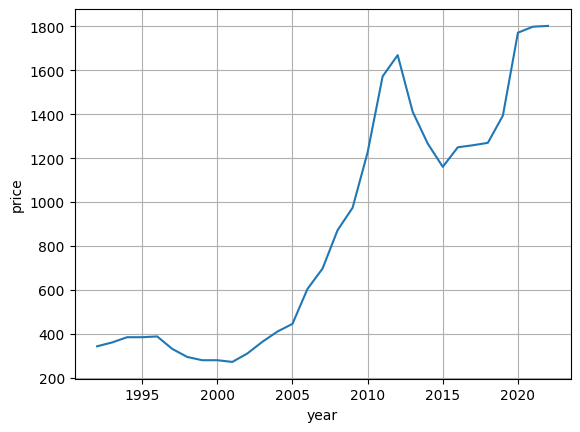

In [2]:
gold_full = pd.read_csv("./../files/gold price full.csv")
sns.lineplot(x = "year", y = "price", data = gold_full.pivot_table(index = "year", aggfunc = {"price":"mean"}))
plt.grid()
plt.show()

get the date and price of the pitfall in around 2015

In [3]:
gold = gold_full[gold_full.year > 2012]
gold[gold.price == gold.price.min()]

,date,price,year
6158,2015-12-02,1053.8,2015


get all the gold price starting around that date. 2016 would be a good starting point. it makes web scraping easier.

In [5]:
gold = gold[~(gold["date"] < "2016-01-01")]
gold.to_csv("gold price.csv", index = False)

##### scrape silver price starting from 2016

In [24]:
header = {"User-Agent":'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'}
silver_base_url = "https://www.usagold.com/daily-silver-price-history/?ddYears="
years = list(range(2016,2023,1))
silver_date = []
silver_price = []
silver_url = []

# defining multiple urls for scraping gold price from each year (1992 - 2017)
for year in years:
    silver_url.append(silver_base_url+str(year))

# start the scraping for each generated url
for url in silver_url:
    r = requests.get(url, headers = header)
    c = r.content
    soup = bs4(c, "html.parser")
    prices = soup.find("div",{"id":"quotes"})
    table = prices.find("table", {"id":"pricehistorytable"})
    all = table.find_all("tr")[2:]
    for i in all:
        try:
            date = i.find_all("td",{"class":"text"})[0].text
        except:
            date = None
        try:
            price = i.find_all("td",{"class":"text"})[1].text
        except:
            price = None
        silver_date.append(date)
        silver_price.append(price)

silver = pd.DataFrame()
silver["date"] = silver_date
silver["price"] = silver_price
silver.to_csv("silver price.csv", index = False)

##### scrape a few stock prices from yahoo finance

In [7]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
# importing time to make delays
import time

In [8]:
def scraping_yfinance(url):
    # --disabling browser popup notifications--
    options = Options()
    options.add_argument("--disable-notifications")
    # to prevent from being spotted as a robot
    options.add_argument('--disable-gpu')
    options.add_argument('user-agent=fake-useragent')
    # installing chromedriver, so that we dont need to keep the chromedriver file
    # that needs to be updated every once in a while. better install the latest automatically
    driver = webdriver.Chrome(ChromeDriverManager().install())
    # opens the browser, maximize window size
    driver.maximize_window()
    # opening url
    driver.get(url)
    # wait a bit until the "I accept" popup shows
    time.sleep(2)
    accept_xpath = "/html/body/div/div/div/div/form/div[2]/div[2]/button"
    accept = driver.find_element(By.XPATH, accept_xpath)
    # clicking "I accept", then wait a bit
    accept.click()
    time.sleep(1)
    later_xpath = "/html/body/div[1]/div/div/div[1]/div/div[4]/div/div/div[1]/div/div/div/div/div/section/button[2]"
    # clicking another popup
    later = driver.find_element(By.XPATH, later_xpath)
    later.click()
    time.sleep(2)
    # since the page is dynamic, meaning the full table wont be shown unless we scroll it,
    # we use selenium to scroll through the page until the bottom page
    # first, getting the page source before scrolling. we will compare it with the
    # page source after scrolling.
    # if html_before != html_after, it means the source is changed after scrolling.
    # in that case, we want to keep scrolling until html_before == html_after
    html1 = driver.page_source
    end = False
    while not end:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, window.scrollY + 1500)") 
        time.sleep(.2)
        driver.execute_script("window.scrollTo(0, window.scrollY + 1500)") 
        time.sleep(.2)
        driver.execute_script("window.scrollTo(0, window.scrollY + 1500)") 
        time.sleep(.2)
        # getting page source after scrolling
        html2 = driver.page_source
        # comparing html_before and html_after
        if html1 == html2:
            end = True
        else:
            html1 = html2
    # YESSS!
    # now that we have the complete page source, we scrape with beautiful soup
    html = driver.page_source
    soup = bs4(html)
    # locating price table
    table = soup.find("div", {"class":"Pb(10px) Ovx(a) W(100%)"})
    # getting all rows from that table (including dates, open price, closing price, etc)
    all = table.find_all("tr", {"class":"BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"})
    dates = []
    prices = []
    df = pd.DataFrame()
    # use loop to get only the 1st and 4th column of each row (date & close price),
    # then save it in lists
    for i in all:
        try:
            date = i.find_all("td")[0].text
        except:
            date = None
        dates.append(date)
        try:
            price = i.find_all("td")[4].text
        except:
            price = None
        prices.append(price)
    # make a dataframe with existing lists
    df["date"] = dates
    df["price"] = prices
    return df

write down the urls we want to scrape from

In [13]:
dowjones_ind_url = "https://finance.yahoo.com/quote/%5EDJI/history?period1=1451606400&period2=1672444800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
dowjones_trans_url = "https://finance.yahoo.com/quote/%5EDJT/history?period1=1451606400&period2=1672444800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
snp_url = "https://finance.yahoo.com/quote/%5EGSPC/history?period1=1451606400&period2=1672444800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
rio_url = "https://finance.yahoo.com/quote/RIO/history?period1=1451606400&period2=1672444800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
copper_url = "https://finance.yahoo.com/quote/SCCO/history?period1=1451606400&period2=1672444800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
newmont_url = "https://finance.yahoo.com/quote/NEM/history?period1=1451606400&period2=1672444800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
#prepare empty dataframes
dj_ind = pd.DataFrame()
dj_trans = pd.DataFrame()
snp = pd.DataFrame()
rio = pd.DataFrame()
copper = pd.DataFrame()
newmont = pd.DataFrame()
# execute scraping process through all the urls
dj_ind = scraping_yfinance(dowjones_ind_url)
dj_trans = scraping_yfinance(dowjones_trans_url)
snp = scraping_yfinance(snp_url)
rio = scraping_yfinance(rio_url)
copper = scraping_yfinance(copper_url)
newmont = scraping_yfinance(newmont_url)
# nasdaq: read csv

C:\Users\mdima\AppData\Local\Temp\ipykernel_9472\4136513956.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
C:\Users\mdima\AppData\Local\Temp\ipykernel_9472\4136513956.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
C:\Users\mdima\AppData\Local\Temp\ipykernel_9472\4136513956.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
C:\Users\mdima\AppData\Local\Temp\ipykernel_9472\4136513956.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
C:\Users\mdima\AppData\Local\Temp\ipykernel_9472\4136513956.py:10: DeprecationWarning: executable_path has been deprecated, please p

In [14]:
dj_ind.to_csv("dow jones industrial stock price.csv", index = False)
dj_trans.to_csv("dow jones tansportation stock price.csv", index = False)
snp.to_csv("snp stock price.csv", index = False)
rio.to_csv("rio tinto stock price.csv", index = False)
copper.to_csv("southern copper stock price.csv", index = False)
newmont.to_csv("newmont stock price.csv", index = False)